In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from __future__ import annotations
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [34]:
from RaTag.datatypes import Run # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.transport as transport # type: ignore
import RaTag.plotting as plotting # type: ignore
import RaTag.transformations as transf # type: ignore
import RaTag.constructors as constructors # type: ignore
import RaTag.analysis as analysis # type: ignore
import RaTag.cuts as cuts # type: ignore
# import RaTag.measurements as meas

# Define RUN5

In [6]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')
meas_path = base_dir / 'FieldScan_5GSsec_Anode2000V_Gate100V'
wfm_paths = sorted(meas_path.glob('*.wfm'))

# S2 area pipeline

## Test in single waveform

<Axes: title={'center': 'RUN5_26052025_Gate100_Anode2000_P6_10000Wfm.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

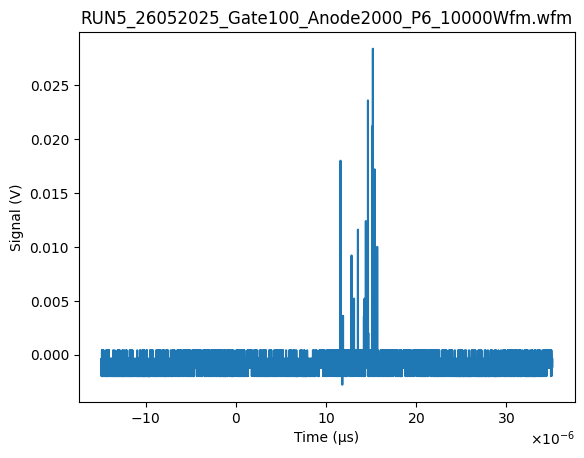

In [7]:
wf = dataIO.load_wfm(str(wfm_paths[0]))
wf.plot()

In [8]:
transf.s2_area_pipeline(wf, t_window = (11.17, 16.17), threshold=0.4, dt = 2e-4)

np.float64(1.4571361031368357)

## Test with single set

In [15]:
set100 = constructors.set_from_dir(meas_path)
set100.filenames[:3]
set100.metadata['anode'], set100.metadata['gate'], set100.metadata.get('gate')

(2000, 100, 100)

In [18]:
areas_100 = analysis.integrate_set_s2(set100, t_window=(11.17, 18.17), n_pedestal=2000, threshold=0.8, dt=2e-4)

<Axes: title={'center': 'S2 Area Histogram for Set FieldScan_5GSsec_Anode2000V_Gate100V'}, xlabel='S2 Area (mV·µs)', ylabel='Counts'>

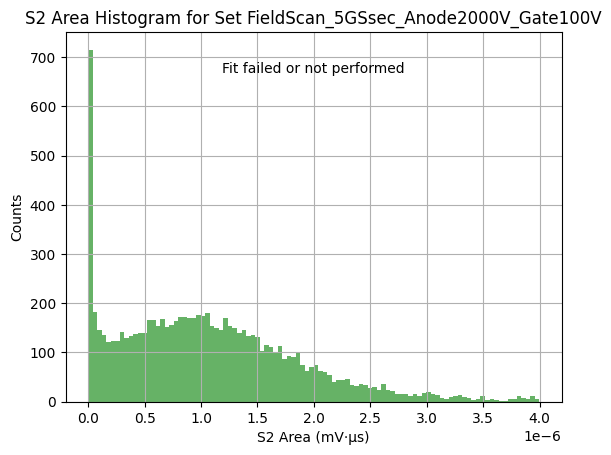

In [32]:
plotting.plot_hist_fit(areas_100, nbins=100, bin_cuts=(0, 4e-6))

# Run analysis

In [ ]:
run5 = Run(
    root_directory = base_dir,
    run_id = "RUN5",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 5.6                # µs 
)

run5 = constructors.populate_run(run5)
run5 = transport.with_gas_density(run5)

run5.gas_density

4.877421222922505e+19

In [41]:
run5.sets[0].metadata

{'sampling_rate': 5000000000.0, 'anode': 2100, 'gate': 200}

In [21]:
results_run5 = integrate_run_s2(run5, n_pedestal=2000, threshold=0.8, )

Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V with t_window: (np.float64(19.522653201926232), np.float64(25.122653201926234))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V with t_window: (np.float64(14.478141857558416), np.float64(20.078141857558414))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V with t_window: (np.float64(12.639508666166433), np.float64(18.239508666166433))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V with t_window: (np.float64(8.847842948237743), np.float64(14.447842948237742))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3000V_Gate1100V with t_window: (np.float64

In [22]:
results_run5['FieldScan_5GSsec_Anode1950V_Gate50V']

S2Areas(set_id=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline)

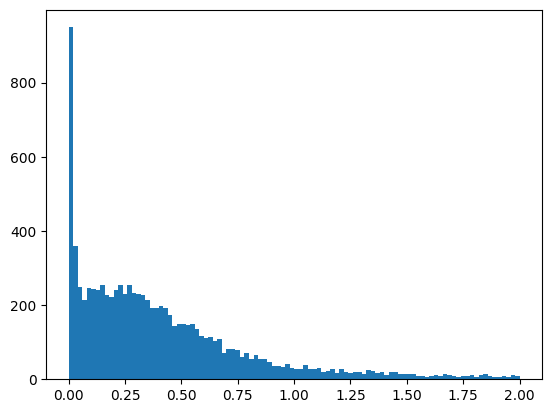

In [23]:
areas100 = results_run5['FieldScan_5GSsec_Anode2000V_Gate100V'].areas
areas100_cut = areas100[areas100 < 2]
plt.hist(areas100_cut, bins=100, histtype='stepfilled');

In [61]:
results_run5

{'FieldScan_5GSsec_Anode1950V_Gate50V': S2Areas(set_id=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2000V_Gate100V': S2Areas(set_id=FieldScan_5GSsec_Anode2000V_Gate100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2100V_Gate200V': S2Areas(set_id=FieldScan_5GSsec_Anode2100V_Gate200V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2500V_Gate600V': S2Areas(set_id=FieldScan_5GSsec_Anode2500V_Gate600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3000V_Gate1100V': S2Areas(set_id=FieldScan_5GSsec_Anode3000V_Gate1100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3500V_Gate1600V': S2Areas(set_id=FieldScan_5GSsec_Anode3500V_Gate1600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode4000V_Gate2100V': S2Areas(set_id=FieldScan_5GSsec_Anode4000V_Gate2100V, n_areas=10001, method=s2_area_pipeline)}

In [98]:
fitted = fit_run_s2(run5, results_run5, nbins=100, bin_cuts=(0, 4), exclude_index=1)

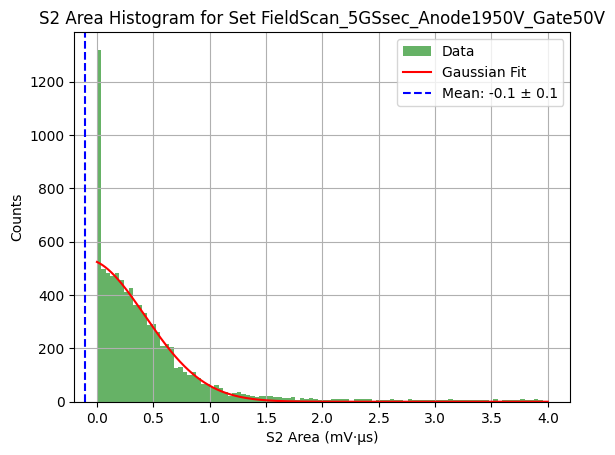

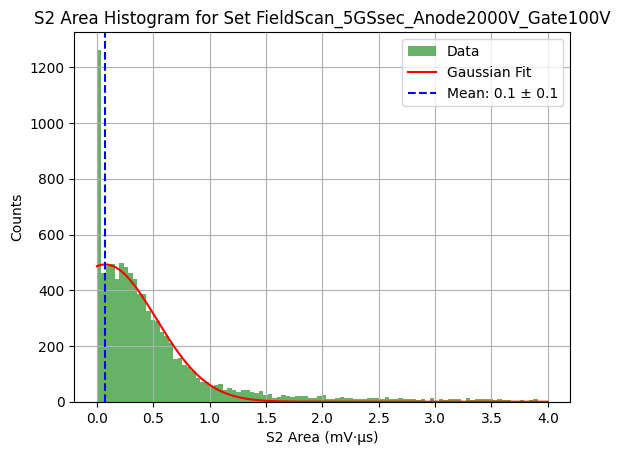

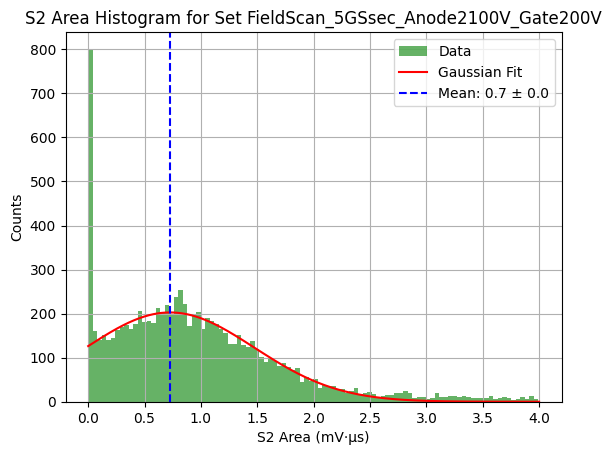

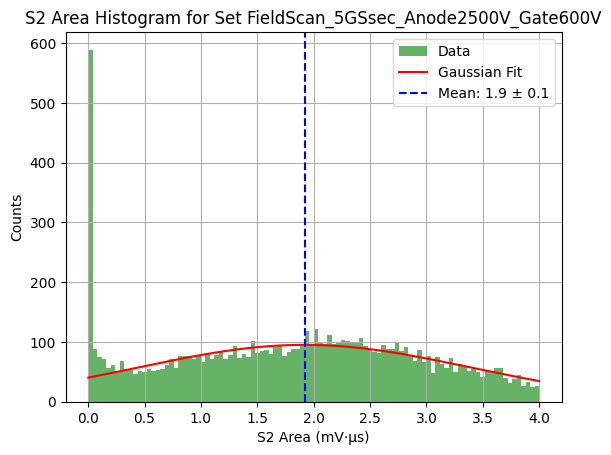

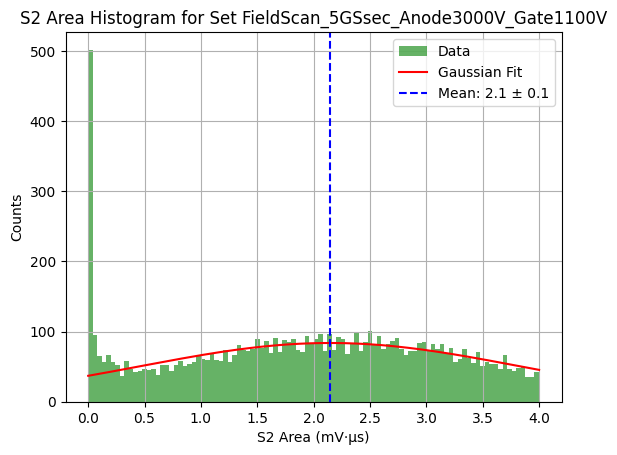

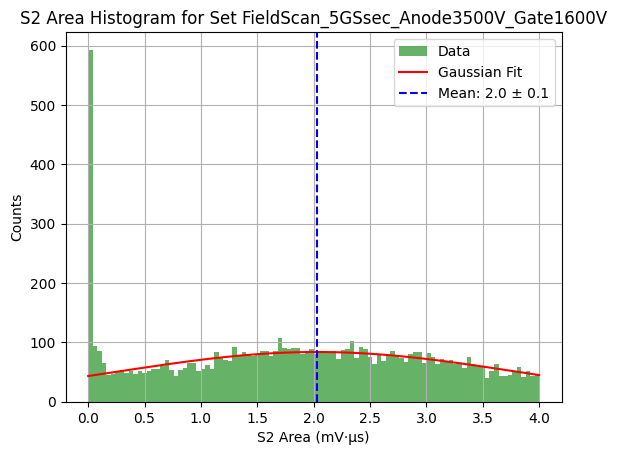

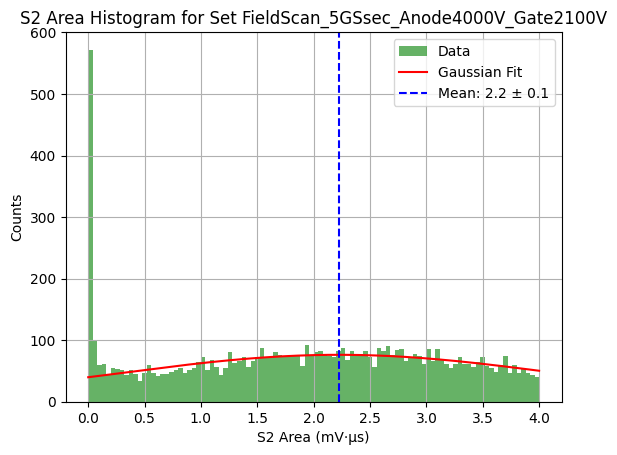

In [96]:
for set_id, fit in fitted.items():
    plotting.plot_hist_fit(fit, nbins=100, bin_cuts=(0, 4));

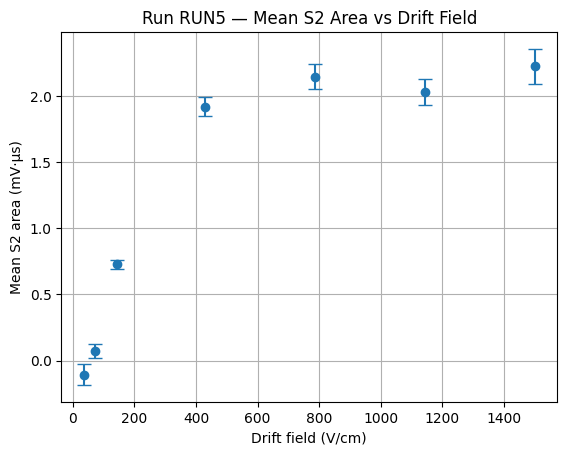

In [97]:
plotting.plot_s2_vs_drift(run5, fitted, )